In [1]:
### read in images:
! pip install opencv-python

     -------------------------------------- 35.6/35.6 MB 930.4 kB/s eta 0:00:00


In [64]:
import cv2 as cv
import numpy as np
import os, json
from typing import Tuple, List
import matplotlib.pyplot as plt
import torch
%load_ext blackcellmagic

## Define some image preprocessing
- we can change the preprocessing later in order to improve our model. The goal is mainly to capture local differences in color.

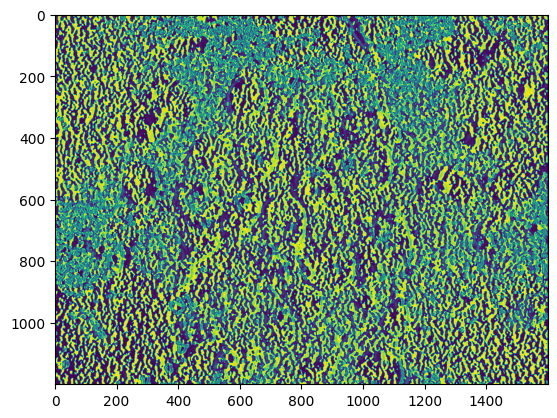

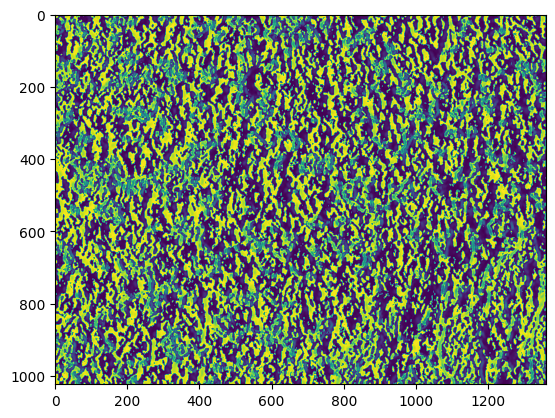

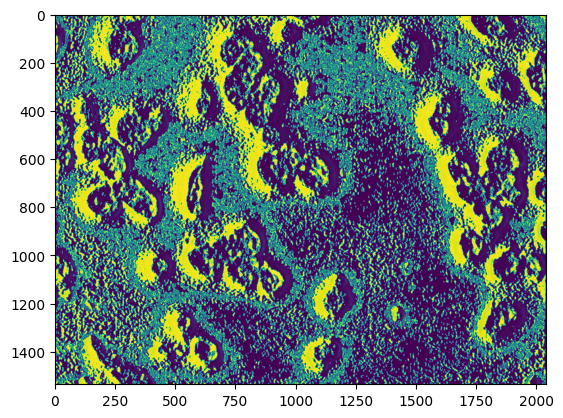

In [102]:
def image_preprocess(im):
    """the goal is to make the result agnostic to color and darkness variations"""
    im = cv.GaussianBlur(im, (7,7), 7)
    # convert image from bgr to hls:
    im = cv.cvtColor(im, cv.COLOR_BGR2HLS)
    # equalize the histogram of the value channel:
    im[:,:,2] = cv.equalizeHist(im[:,:,2])
    # for all 3 channels calculate sobel
    for i in [0]:
        im[:,:,i] = cv.GaussianBlur(im[:,:,i], (7,7), 7)
        im[:,:,i] = cv.Sobel(im[:,:,i], cv.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv.BORDER_DEFAULT)
    return im

for path in ["output/images/1.jpg", "output/images/2.jpg", "output/images/3.jpg"]:
    im = cv.imread(path)
    im = image_preprocess(im)
    # cv.imwrite(path + ".prep.jpg", im)
    plt.imshow(im[:,:,0])
    plt.show()

## Constants

In [105]:
TARGET_BOUNDS_LENGTH = 64

## Data loading and preprocessing

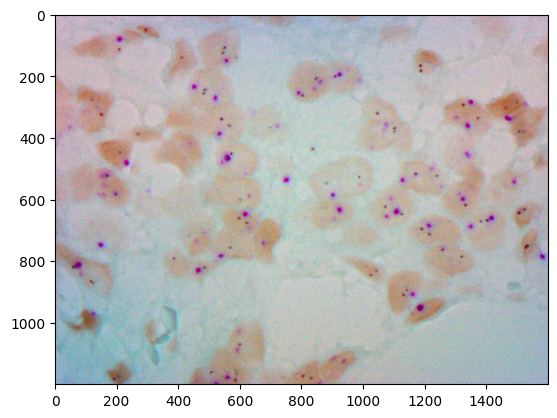

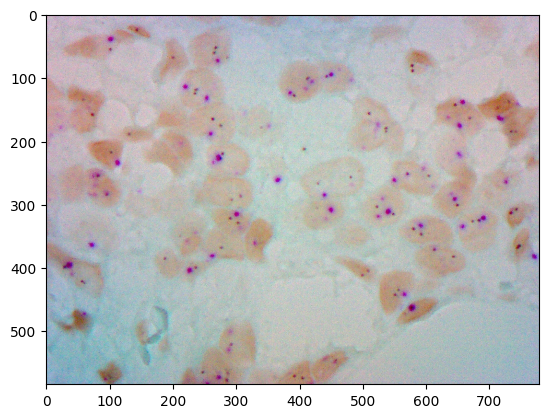

In [114]:
from typing import Any, Dict
from shapely.geometry import Polygon, Point

class AnnotationPoly():
    """A polygon from a list of points"""
    points: List[Tuple[float, float]]
    _polygon: Polygon
    # (y, x) points of the surrounding
    def __init__(self, json: Dict[str, Any]) -> None:
        strX = [float(s) for s in json["Points"][0]["X"].split(",")]
        strY = [float(s) for s in json["Points"][0]["Y"].split(",")]
        self.points = []
        for (y,x) in zip(strY, strX):
            self.points.append((y,x))
        self._polygon = Polygon(self.points)

    def bounds_size(self) -> Tuple[float, float]:
        """returns (height,width) of the area enclosed"""   
        minx, miny, maxx, maxy = self._polygon.bounds
        return (maxy-miny, maxx-minx)

    def bounds_avg_size(self):
        h,w = self.bounds_size()
        return (h+w)/2

    def area(self):
        return self._polygon.area

    def contains_point(self, point: Tuple[float, float]):
        self._polygon.within(Point(point[0], point[1]))

    def center(self):
        return self._polygon.centroid 

class TrainImage():
    annotations : List[AnnotationPoly]
    histogram: np.ndarray
    resized: np.ndarray
    def __init__(self, partial_path: str) -> None:
        """expects partial_path to be like: "DISH1/125121A_S20200928_0014"
            - looks for data/reference/DISH1/125121A_S20200928_0014/ndmctsgh.json
            - looks for data/sampleinput/DISH1/125121A_S20200928_0014.jpg
        """
        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        json_path = f"data/reference/{partial_path}/ndmctsgh.json"

        # read metadata from json
        f = open(json_path)
        j = json.load(f)
        f.close()
        annotations = []
        for a in j["annotations"]:
            annotations.append(AnnotationPoly(a))
        self.annotations = annotations

        # read image and preprocess it to form features:
        img = cv.imread(jpg_path)
        hist, bins = np.histogram(img.ravel(),bins=[e for e in range(256)])
        hist = hist / np.sum(hist)
        plt.bar(range(0,255),hist)

        # resize image such that the average bounds length of an annotation is 
        avg_bounds_length = np.mean([a.bounds_avg_size() for a in self.annotations])
        (h,w,_) = img.shape
        (newh, neww) = int(TARGET_BOUNDS_LENGTH / avg_bounds_length * h), int(TARGET_BOUNDS_LENGTH / avg_bounds_length * w)
        print("original: ")
        plt.imshow(img)
        plt.show()
        resized = cv.resize(img, (neww, newh))
        print("resized: ")
        plt.imshow(resized)
        plt.show()
        
    
im1 =TrainImage("DISH1/125121A_S20200928_0014")
        

## constructing a neural net for predictions

we want to be able to predict for every 10th pixel in x and y direction.


In [65]:
all_train_images_partial_paths = [
    "DISH1/125121A_S20200928_0014",
    "DISH1/125121A_S20200928_0017",
    "DISH1/1931427A_S20200928_0005",
    "DISH1/1931427A_S20200928_0014",
    "DISH1/2004994A_S20201013_0001"
    "DISH2/1(2)"
    "DISH2/5(2)"
    "DISH2/DISH3"
    "DISH2/P002120277A-2"
    "DISH2/P002124864A-1"
    "FISH/12-09-12P0012201890-2"
    "FISH/12-09-12P0012201893-1"
    "FISH/12-09-13P001220195-1"
    "FISH/P001506473(P001805365A)-1"
    "FISH/P001531546(P001529027C)9",
]

class ImageDataset(torch.Dataset):
    def __init__(self, partial_paths : List[str]) -> None:
        for partial_path in partial_paths:
            train_image = TrainImage(partial_path)


        pass

In [70]:

from shapely.geometry import Polygon, Point
p = Polygon([(0,0), (1,0),(1,1), (0,1)])

p.contains(Point(0.5,0.5))

True

['label.png']
